In [131]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from scipy.io import loadmat
import numpy as np
import math

In [128]:
## Read images, check all jpg images in path and read them.
## Return a list of images each with a matrix of height * width * 3(channels for colors).
def read_images(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('jpg')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.jpg';
        total_path = join(path,file);
        img = mpimg.imread(total_path);
        data.append(img);
    return onlyfiles, data;
## Read ground truth from mat files.
## Only care about segmented images, throw away boundary images.
## Return a list of a list of ground truth images.
def read_ground_truth(path):
    onlyfiles = [f[:-4] for f in listdir(path) if isfile(join(path, f)) and f.endswith('mat')];
    onlyfiles.sort(key=int);
    data = [];
    for file in onlyfiles:
        file = file + '.mat';
        total_path = join(path,file);
        img = loadmat(total_path);
        process_img = [];
        for k in np.squeeze(img['groundTruth']).reshape(-1):
            process_img.append(k[0][0][0]);
            ## If we want boundary images with us.
            #for c in k[0][0]:
                #process_img.append(c);
        data.append(process_img);
    return data;
## Show image with its ground truths.
def show_img(real_data, gt_data, names, index):
    kn = 1 + len(gt_data[index]);
    n = int(math.sqrt(kn));
    mn = n;
    if (mn * n < kn):
        mn = mn + 1;
        if (mn * n < kn):
            n = n + 1;
    fig, ax = plt.subplots(n, mn, figsize=(20,20));
    fig.suptitle('Image ' + names[index], fontsize=20)
    ax[0][0].imshow(real_data[index]);
    for i in range(len(gt_data[index])):
        rem = (i + 1) % mn;
        k = int((i + 1) / mn);
        ax[k, rem].imshow(gt_data[index][i]);
    plt.show();

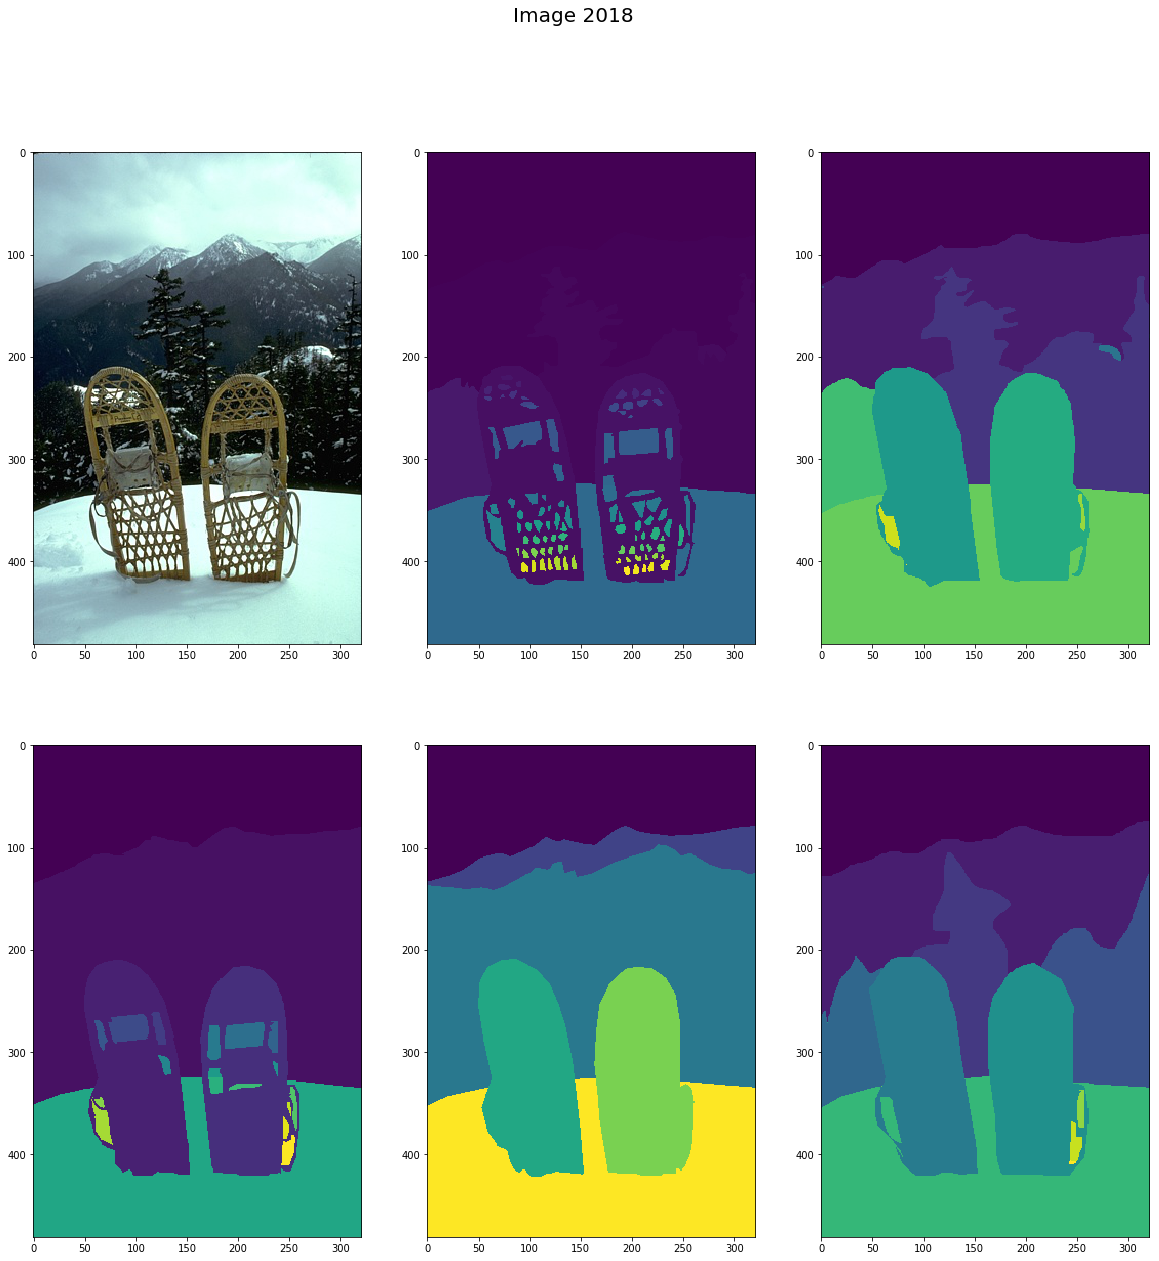

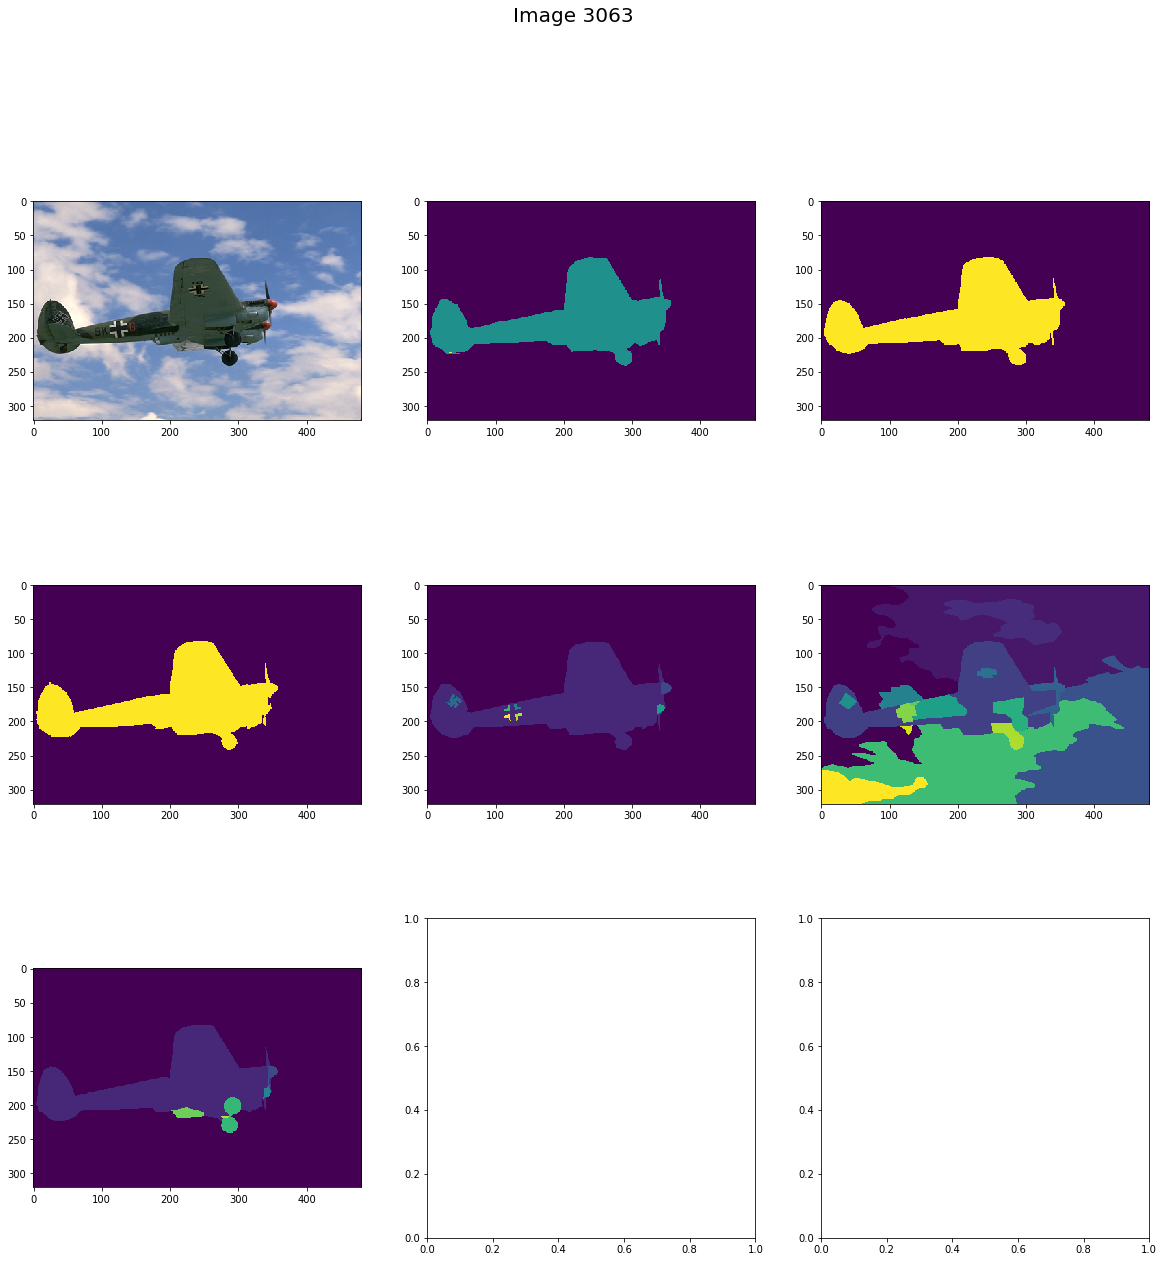

In [132]:
names, real_data = read_images('data/images/test');
real_gt = read_ground_truth('data/groundTruth/test');
show_img(real_data, real_gt, names, 0);
show_img(real_data, real_gt, names, 1);

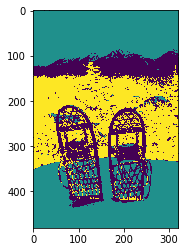

Starting with k :  3


KeyboardInterrupt: 

In [143]:
## K-Means with different k
k_param = [3,5,7,9,11];
k_results = [];
for k in k_param:
    min_k = [];
    i = 0;
    print('Starting with k : ', k);
    for img in real_data:
        img_u = img.reshape(-1, 3);
        kmeans = KMeans(n_clusters=k, random_state=0).fit(img_u);
        min_k.append(kmeans.labels_.reshape(img.shape[:-1]));
        i = i + 1;
        if (i % 20 == 0):
            print('Finished : ', i / 2, '%')
    k_results.append(min_k);